In [ ]:
# Set-up
'''
Please Download/Move the data into the 'base_path' directory
'''
# Downloading the DataSet
# base_path = "./datasets"  # path/to/storage
# well_download(base_path=base_path, dataset="active_matter", split="train")
# well_download(base_path=base_path, dataset="active_matter", split="valid")
# well_download(base_path=base_path, dataset="active_matter", split="test")

In [1]:
from DatasetModule import MyDataset, plot_datapoint
import matplotlib.pyplot as plt 

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Exploring the full dataset

In [27]:
# Checking the number of repetitions in each data set
train_data = MyDataset('train', xlen=81, ylen=0)
valid_data = MyDataset('valid', xlen=81, ylen=0)
test_data = MyDataset('test', xlen=81, ylen=0)

print(f'Total number of simulations in the training dataset: {len(train_data)}')
print(f'Total number of simulations in the validation dataset: {len(valid_data)}')
print(f'Total number of simulations in the test dataset: {len(test_data)}')

print(f'\nTotal number of simulations in the whole dataset: {len(train_data)+len(valid_data)+len(test_data)}')

Total number of simulations in the training dataset: 175
Total number of simulations in the validation dataset: 24
Total number of simulations in the test dataset: 26

Total number of simulations in the whole dataset: 225


In [28]:
print(train_data.raw.constant_scalar_names)
x = train_data.raw[0]
print(x.keys())
x['input_fields'].shape

['L', 'zeta', 'alpha']
dict_keys(['input_fields', 'constant_scalars', 'boundary_conditions', 'space_grid', 'input_time_grid'])


torch.Size([81, 256, 256, 11])

In [ ]:
# Check how many pairs of alpha zeta values are in each dataset
tl = []
for i in range(len(train_data.raw)):
    # print(f'id: {i}, -> {train_data.raw[i]['constant_scalars']}')
    tl.append(train_data.raw[i]['constant_scalars'][1:])
unique_tuples = {tuple(t.tolist()) for t in tl}
print(f'In the training dataset there are {len(unique_tuples)} pairs of (zeta, alpha) values.')

vl = []
for i in range(len(valid_data.raw)):
    # print(f'id: {i}, -> {valid_data.raw[i]['constant_scalars']}')
    vl.append(valid_data.raw[i]['constant_scalars'][1:])
unique_tuples = {tuple(t.tolist()) for t in vl}
print(f'In the validation dataset there are {len(unique_tuples)} pairs of (zeta, alpha) values.')

tsl = []
for i in range(len(test_data.raw)):
    # print(f'id: {i}, -> {test_data.raw[i]['constant_scalars']}')
    tsl.append(test_data.raw[i]['constant_scalars'][1:])
unique_tuples = {tuple(t.tolist()) for t in tsl}
print(f'In the test dataset there are {len(unique_tuples)} pairs of (zeta, alpha) values.')

In the training dataset there are 45 pairs of (zeta, alpha) values.
In the validation dataset there are 16 pairs of (zeta, alpha) values.
In the test dataset there are 21 pairs of (zeta, alpha) values.


In [ ]:
unique_frames = {}

for dd in [train_data.raw, valid_data.raw, test_data.raw]:
    for i in range(len(dd)):
        item = dd[i]
        # Extract scalar values
        scalars = item['constant_scalars']
        # Ensure we are using Python floats/ints for dictionary keys
        zeta = round(float(scalars[1])) 
        alpha = round(float(scalars[2]))
        
        # Check if zeta is already a key
        if zeta not in unique_frames:
            unique_frames[zeta] = {}
        
        # Only store the frame if the (zeta, alpha) combination hasn't been seen yet
        if alpha not in unique_frames[zeta]:
            frame_data = item['input_fields'][41, :, :, 0]
            unique_frames[zeta][alpha] = frame_data

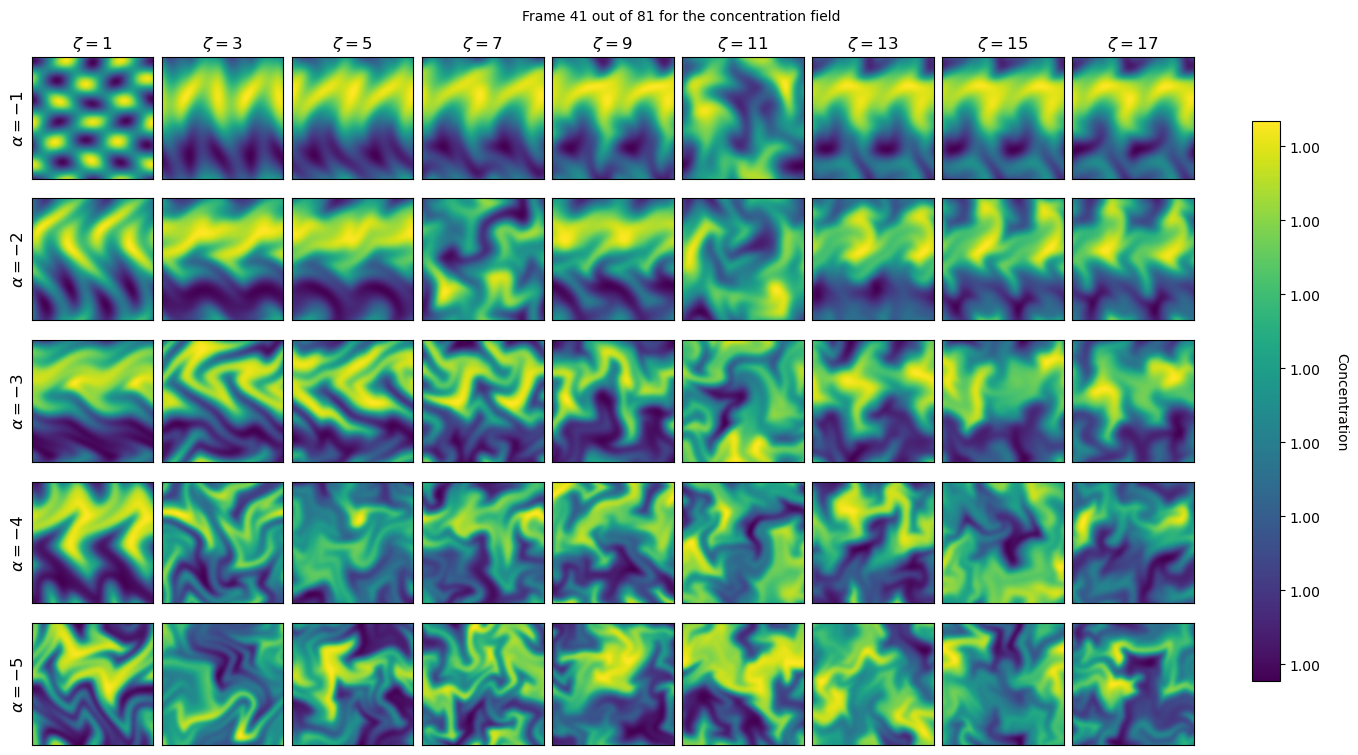

In [14]:
# --- Grid Plotting Configuration ---

sorted_zeta = sorted(unique_frames.keys()) 
sorted_alpha = sorted(list(unique_frames[sorted_zeta[0]].keys()), reverse=True)

# alpha = rows, zeta = cols
num_rows = len(sorted_alpha) 
num_cols = len(sorted_zeta)

fig, axes = plt.subplots(
    nrows=num_rows, 
    ncols=num_cols, 
    figsize=(num_cols * 1.5, num_rows * 1.5), 
    sharex=True, 
    sharey=True,
    constrained_layout=True
)

fig.suptitle('Frame 41 out of 81 for the concentration field', fontsize=10)

# Loop through the grid
for i, alpha in enumerate(sorted_alpha):
    for j, zeta in enumerate(sorted_zeta):
        ax = axes[i, j]
        
        # Extract the frame from the processed dictionary
        frame = unique_frames.get(zeta, {}).get(alpha)
        
        if frame is not None:
            im = ax.imshow(frame, cmap='viridis', origin='lower')
        
        # --- Clean Edge Labeling Logic ---
        
        # Only label the Y-axis (alpha) on the very first column
        if j == 0:
            ax.set_ylabel(f"$\\alpha = {alpha}$", fontweight='bold', fontsize=12)
        else:
            ax.set_ylabel("")

        # Only label the X-axis (zeta) on the very top row
        if i == 0:
            ax.set_title(f"$\\zeta = {zeta}$", fontweight='bold', fontsize=12)
        
        # Remove all internal ticks for a clean "image grid" look
        ax.set_xticks([])
        ax.set_yticks([])

# Add a colorbar with a label
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, format="%.2f")
cbar.set_label("Concentration", rotation=270, labelpad=20)

plt.savefig("figures/alpha_zeta-grid.svg")
plt.show()
plt.close()

In [13]:
n=3
x = train_data.raw[n]['input_fields']
ts = train_data.raw[n]['input_time_grid']
X = train_data.raw[n]['space_grid']
# Example data: 3D array (n_frames, height, width)
data = x[:,:,:,0]

# Create figure and first image
fig, ax = plt.subplots(figsize=1.1*plt.figaspect(1/1.2))
im = ax.pcolor(X[:,:,0],X[:,:,1],data[0], cmap='viridis_r',
               vmin=data.min(), vmax=data.max())
ax.set_title(f"t = {ts[0]}")
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = fig.colorbar(im, format="%.2f")
cbar.set_label("Concentration")

# Update function
def update(frame):
    im.set_array(data[frame])
    ax.set_title(f"t = {ts[frame]}")
    return [im]

# Create animation
ani = FuncAnimation(fig, update, frames=len(data), interval=100, blit=True)

plt.close(fig)
ani.save('figures/Concentration_repetition_train-3.gif', writer='pillow', fps=10)
# Display animation inline in Jupyter
HTML(ani.to_jshtml())

# The fordward problem (predict the 5th frame form 4 previous ones)

In [2]:
training_data = MyDataset('train')

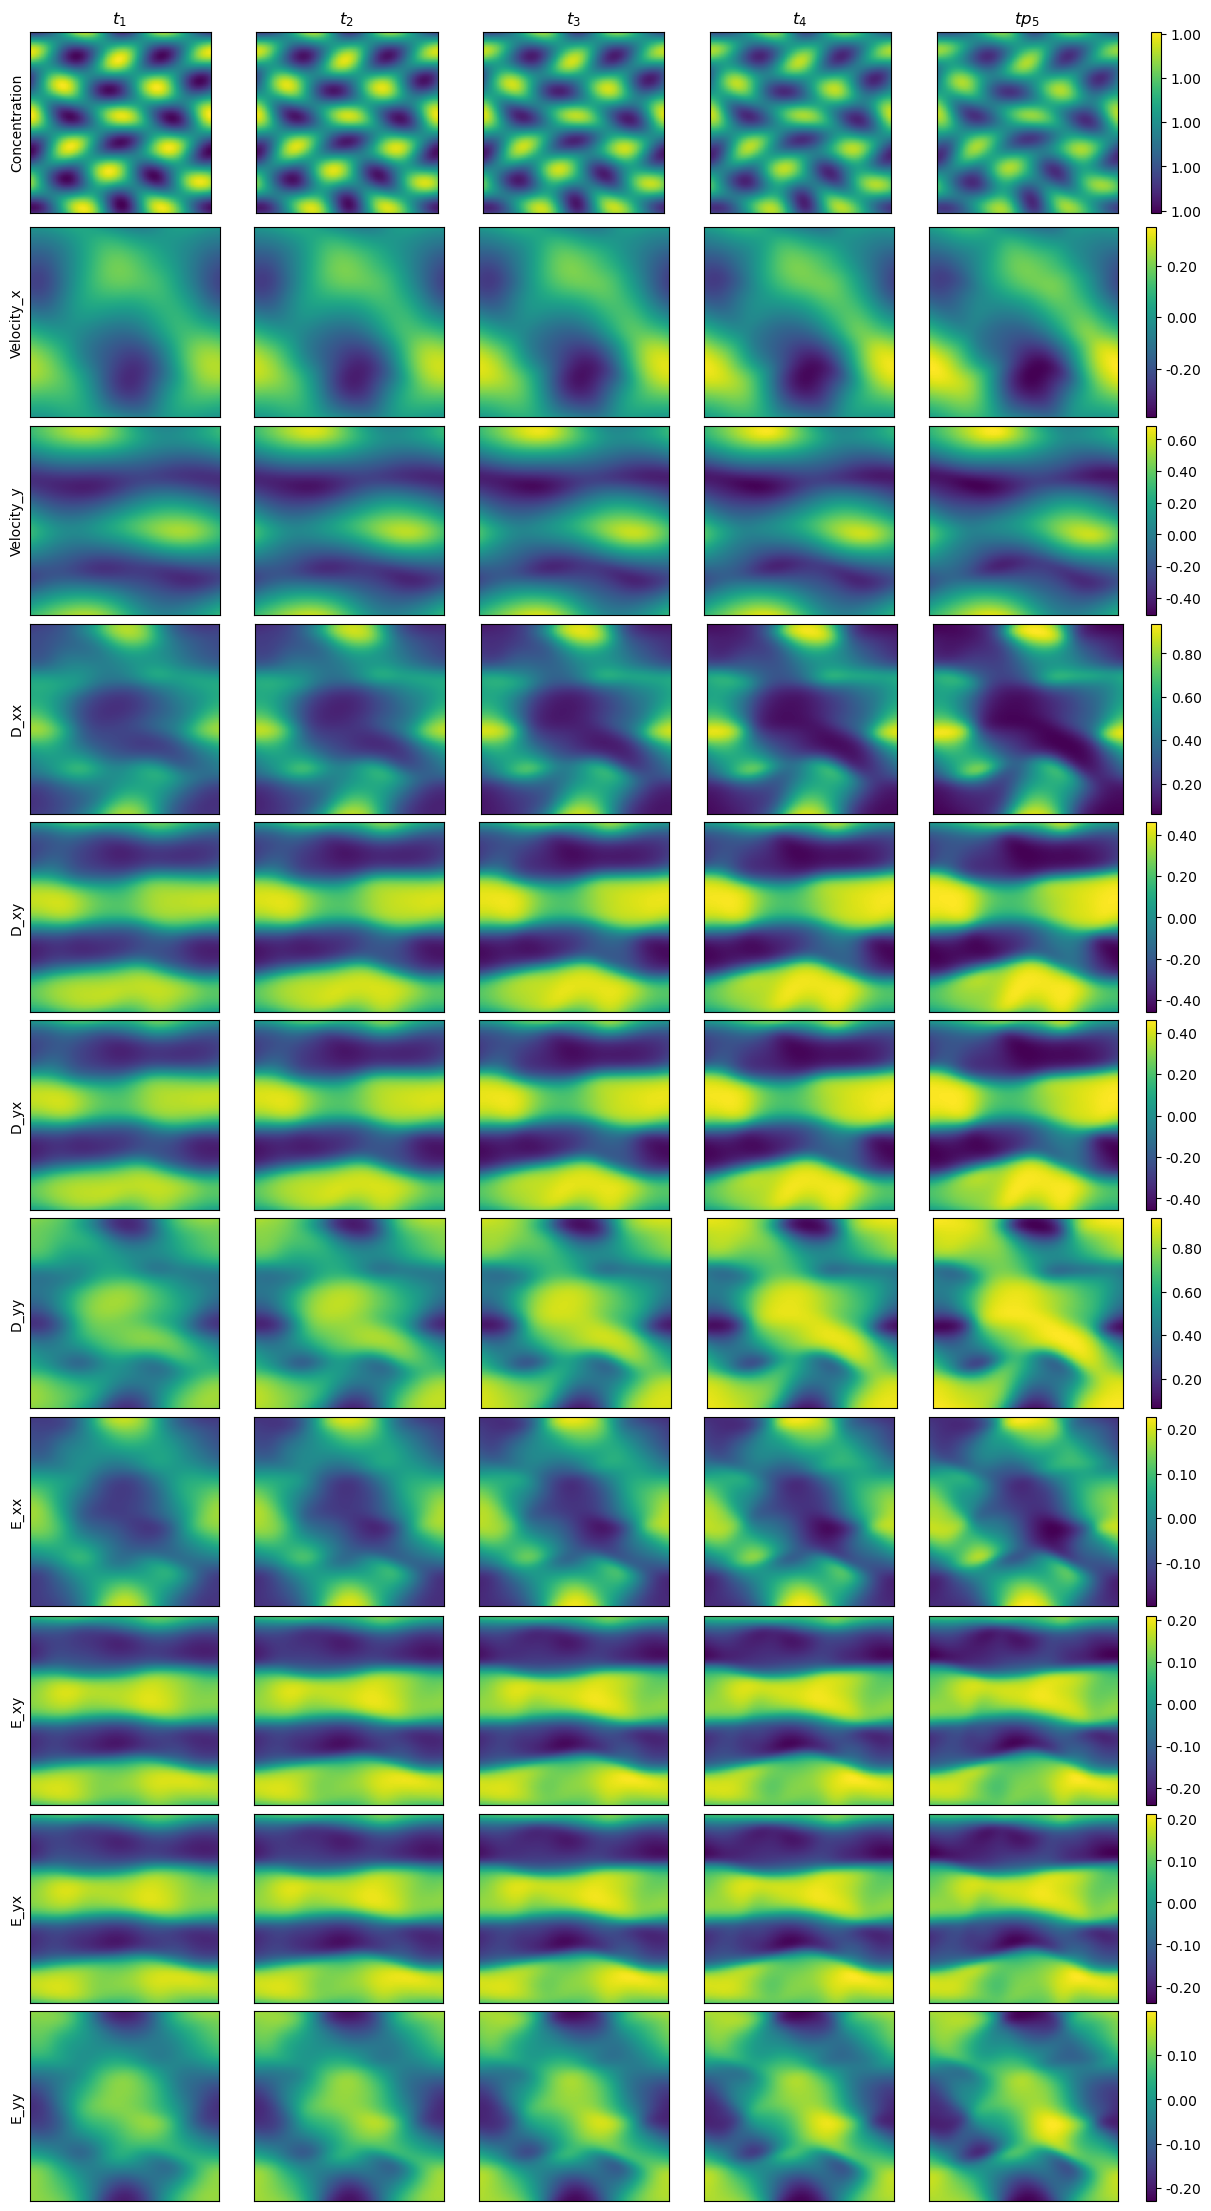

In [3]:
plot_datapoint(*training_data[42])
plt.savefig("figures/Explorartory42.svg")
plt.show()
plt.close()